In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
##import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [50]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [15]:
!tar -xf lfw.tgz

In [24]:
# move lfw to negetive
for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    for file in os.listdir(dir_path):
        EX_PATH = os.path.join(dir_path, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [5]:

import uuid #geneerate unique image name

In [8]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame=  cap.read()
    
    ##cut framme to 250x250px
    frame = frame[120:120+250, 200:200+250, :]
    
    ## capture anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, frame)
    
    ## capture positive
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname1 = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname1, frame)
    
    cv2.imshow('Image Collection', frame)
     
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
    

cap.release()
cv2.destroyAllWindows()

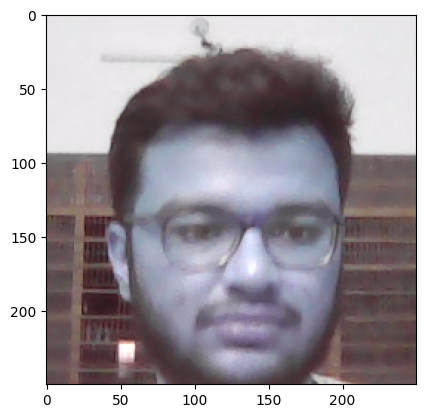

In [11]:
plt.imshow(frame)

## Load and preprocess data

In [4]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [5]:
dir_test = anchor.as_numpy_iterator()

In [6]:
dir_test.next()

b'data\\anchor\\63c7f68b-b31e-11ef-9760-e8fb1cbafb2a - Copy.jpg'

In [7]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)#read in image from file path
    img = tf.io.decode_jpeg(byte_img)# load in img
    img = tf.image.resize(img, (100, 100))
    img = img /255.0
    return img

In [8]:
#(anchor, positive) => 1,1,1
#(anchor, negtive) =>0, 0, 0

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:

samples = data.as_numpy_iterator()

In [11]:

exampple = samples.next()

In [12]:

exampple

(b'data\\anchor\\60740b19-b31e-11ef-a1ce-e8fb1cbafb2a - Copy (2).jpg',
 b'data\\positive\\5eac2092-b31e-11ef-b870-e8fb1cbafb2a.jpg',
 np.float32(1.0))

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [14]:
res = preprocess_twin(*exampple)

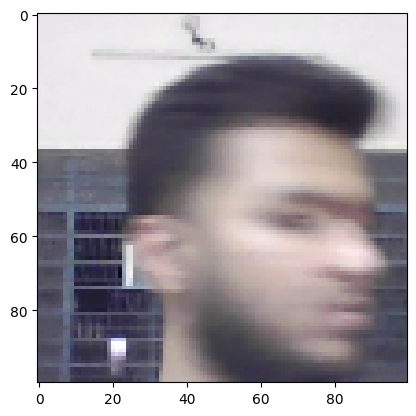

In [15]:
plt.imshow(res[1])

In [16]:
res[2]

np.float32(1.0)

In [17]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [18]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [19]:
samples = data.as_numpy_iterator()

In [20]:
samples.next()

(array([[[0.90588236, 0.8980392 , 0.9019608 ],
         [0.90588236, 0.8980392 , 0.9019608 ],
         [0.90588236, 0.8980392 , 0.9019608 ],
         ...,
         [0.90686274, 0.9098039 , 0.8931373 ],
         [0.9098039 , 0.9098039 , 0.9078431 ],
         [0.9098039 , 0.9098039 , 0.9098039 ]],
 
        [[0.90588236, 0.8980392 , 0.90392154],
         [0.9098039 , 0.9019608 , 0.9078431 ],
         [0.90612745, 0.8982843 , 0.90416664],
         ...,
         [0.90686274, 0.90686274, 0.8995098 ],
         [0.90906864, 0.90906864, 0.907598  ],
         [0.90588236, 0.90588236, 0.9078431 ]],
 
        [[0.90588236, 0.8980392 , 0.9098039 ],
         [0.90612745, 0.8982843 , 0.910049  ],
         [0.90686274, 0.8990196 , 0.9107843 ],
         ...,
         [0.90588236, 0.90588236, 0.9044118 ],
         [0.90588236, 0.90588236, 0.9102941 ],
         [0.9019608 , 0.9019608 , 0.9098039 ]],
 
        ...,
 
        [[0.3137255 , 0.3019608 , 0.37843138],
         [0.3095588 , 0.2977941 , 0.37573

In [21]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [23]:
sample = train_data.as_numpy_iterator()


In [24]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [25]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## Siamese neural network

In [26]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [27]:
embedding = make_embedding()

In [28]:

embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)

In [30]:

l1 = L1Dist()

In [31]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [32]:

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [33]:

siamese_layer = L1Dist()

In [34]:

distances = siamese_layer(inp_embedding, val_embedding)

In [35]:
classifier = Dense(1, activation='sigmoid')(distances)

In [36]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_12>

In [37]:
def make_siamese_model():
    
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    validation_image = Input(name = 'validation_img', shape=(100, 100, 3))
    
    siamese_layer = L1Dist()
    siamese_layer._name ='distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1 , activation='sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier , name ='siameseNetwork')
    

In [38]:
siamese_model = make_siamese_model()

In [39]:
siamese_model.summary()

Model: "siameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [40]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [41]:
opt = tf.keras.optimizers.Adam(1e-4)

In [42]:
checkpoint_dir = './training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt= opt, siammese_model= siamese_model)

In [43]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        
        X = batch[:2]# Get anchor and positive/negetive image
        
        y = batch[2]# get Label
        y = tf.reshape(y, (-1, 1))
        yhat = siamese_model(X, training= True)# forward pas
        yhat = tf.reshape(yhat, (-1, 1))        
        
        loss = binary_cross_loss(y, yhat) # calcualte pass
    print(loss)
    # calcualte gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # calculate updated weigth and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [44]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n EPOCH {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch %10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [45]:
EPOCHS = 50

In [46]:
train(train_data, EPOCHS)


 EPOCH 1/50


f:\Face recognition using yolo\yoloenv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)


f:\Face recognition using yolo\yoloenv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(4, 100, 100, 3))
  warnings.warn(msg)


27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 EPOCH 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step

 EPOCH 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step

 EPOCH 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 EPOCH 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

 EPOCH 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

 EPOCH 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

 EPOCH 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 EPOCH 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 EPOCH 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

 EPOCH 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

 EPOCH 20/50
2

In [48]:
from tensorflow.keras.metrics import Precision, Recall

In [49]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [50]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

f:\Face recognition using yolo\yoloenv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


array([[[9.9933362e-01],
        [9.9999851e-01],
        [7.0901768e-10],
        [9.9999821e-01],
        [9.9999267e-01],
        [8.1715024e-11],
        [1.0000000e+00],
        [1.8557378e-11],
        [1.0000000e+00],
        [9.9839544e-01],
        [5.0053681e-09],
        [1.0000000e+00],
        [4.7122451e-13],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.8491617e-12]]], dtype=float32)

In [52]:
y_true

array([1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [54]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

np.float32(1.0)

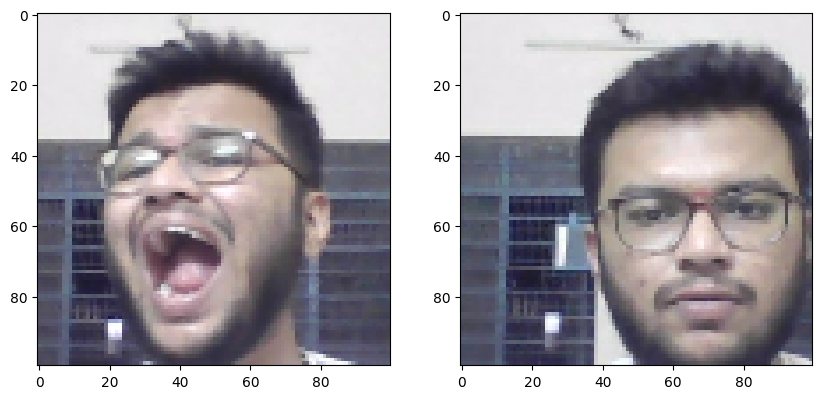

1.0


In [61]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[3])
plt.show()
print(y_true[3])


In [58]:
siamese_model.save('siamese_model.h5')

In [59]:
model = tf.keras.models.load_model('siamese_model.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [60]:
model.summary()

Model: "siameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)